In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import joblib

# Càrrega del dataset original
df = pd.read_csv(Path("../data/dataset_estudiantes.csv"))

# Crear 'aprobado' si cal
if 'aprobado' not in df.columns:
    df['aprobado'] = (df['nota_final'] >= 60).astype(int)

# Variables
target = 'aprobado'
features = [c for c in df.columns if c not in ['nota_final', 'aprobado']]

X = df[features]
y = df[target]

# Train/test split amb estratificació
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Carreguem el preprocesador
pre = joblib.load(Path("../modelos/preprocesador.pkl"))
X_train_p = pre.transform(X_train)
X_test_p = pre.transform(X_test)

X_train_p.shape, X_test_p.shape


((800, 17), (200, 17))

In [2]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

def eval_class(y_true, y_pred, y_proba, model_name):
    return {
        "modelo": model_name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }


In [3]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log.fit(X_train_p, y_train)

y_pred_log = log.predict(X_test_p)
y_proba_log = log.predict_proba(X_test_p)[:, 1]

res_log = eval_class(y_test, y_pred_log, y_proba_log, "LogisticRegression")
res_log


{'modelo': 'LogisticRegression',
 'accuracy': 0.7,
 'precision': 0.9477611940298507,
 'recall': 0.7055555555555556,
 'f1': 0.8089171974522293,
 'roc_auc': 0.8122222222222222}

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_p, y_train)

y_pred_rf = rf.predict(X_test_p)
y_proba_rf = rf.predict_proba(X_test_p)[:, 1]

res_rf = eval_class(y_test, y_pred_rf, y_proba_rf, "RandomForestClassifier")
res_rf


{'modelo': 'RandomForestClassifier',
 'accuracy': 0.9,
 'precision': 0.9040404040404041,
 'recall': 0.9944444444444445,
 'f1': 0.9470899470899471,
 'roc_auc': 0.773888888888889}

In [5]:
pd.DataFrame([res_log, res_rf]).sort_values("f1", ascending=False)


,modelo,accuracy,precision,recall,f1,roc_auc
1,RandomForestClassifier,0.9,0.904040,0.994444,0.947090,0.773889
0,LogisticRegression,0.7,0.947761,0.705556,0.808917,0.812222


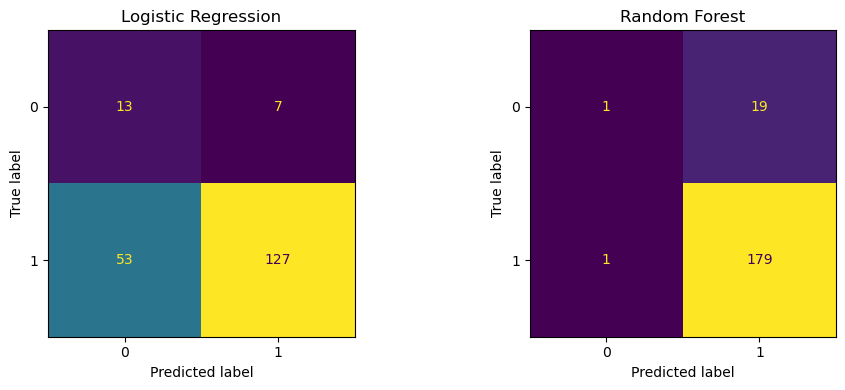

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, ax=axs[0], colorbar=False)
axs[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axs[1], colorbar=False)
axs[1].set_title("Random Forest")

plt.tight_layout()
plt.show()


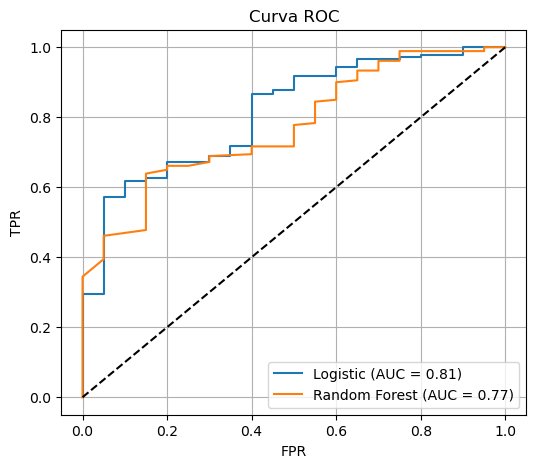

In [7]:
from sklearn.metrics import roc_curve

fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label="Logistic (AUC = {:.2f})".format(res_log["roc_auc"]))
plt.plot(fpr_rf, tpr_rf, label="Random Forest (AUC = {:.2f})".format(res_rf["roc_auc"]))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend(); plt.grid(); plt.show()
